In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

from scipy.ndimage.filters import gaussian_filter

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
ccdnum_list = [1, 2, 3, 4]
ccd_ra = [0.2813, 0.2813, -0.2813, -0.2813]
ccd_dec = [0.263, -0.263, 0.263, -0.263]

In [4]:
plot_dir = '/global/project/projectdirs/desi/www/users/rongpu/plots/dr9dev/90prime_images/'
image_dir = '/global/cfs/cdirs/cosmo/staging/'
band = 'r'

dr9 = Table.read('/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-90prime-dr9.fits.gz')
dr8 = Table.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-ccds-90prime-dr8.fits.gz')

mask = dr9['ccd_cuts']==0
mask &= dr9['filter']==band
dr9 = dr9[mask]
print(len(dr9))

mask = dr8['ccd_cuts']==0
mask &= dr8['filter']==band
dr8 = dr8[mask]
print(len(dr8))

66756
66544


In [5]:
# Require all 4 CCDs
expnum, count = np.unique(dr9['expnum'], return_counts=True)
mask = count==4
mask = np.in1d(dr9['expnum'], expnum[mask])
print(np.sum(mask)/len(mask))
dr9 = dr9[mask]
expnum, count = np.unique(dr8['expnum'], return_counts=True)
mask = count==4
mask = np.in1d(dr8['expnum'], expnum[mask])
print(np.sum(mask)/len(mask))
dr8 = dr8[mask]

# Keep only overlapping exposures
mask = np.in1d(dr9['expnum'], dr8['expnum'])
print(np.sum(mask)/len(mask))
dr9 = dr9[mask]

mask = np.in1d(dr8['expnum'], dr9['expnum'])
print(np.sum(mask)/len(mask))
dr8 = dr8[mask]

print(len(dr8), len(dr9))

0.995506021931
0.991163741284
0.988563861803
0.996057978046
65696 65696


In [6]:
index = 0
image_path = os.path.join(image_dir, dr9['image_filename'][index].strip())
print(os.path.isfile(image_path), image_path)

image_path_dr8 = os.path.join(image_dir, dr8['image_filename'][index].strip().replace('90prime/BOK_CP/', '90prime/CP/'+dr8['plver'][index]+'/'))
print(os.path.isfile(image_path_dr8), image_path_dr8)

True /global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20180309/ksb_180310_120315_ooi_r_ls9.fits.fz
True /global/cfs/cdirs/cosmo/staging/90prime/CP/V2.1/CP20180309/ksb_180310_110232_ooi_r_v1.fits.fz


In [7]:
expnum_list = np.unique(dr9['expnum'])
np.random.seed(123)
expnum_list = np.random.choice(expnum_list, size=20, replace=False)

expnum: 78320109
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.0/CP20170319/ksb_170320_052234_ooi_r_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20170319/ksb_170320_052234_ooi_r_ls9.fits.fz


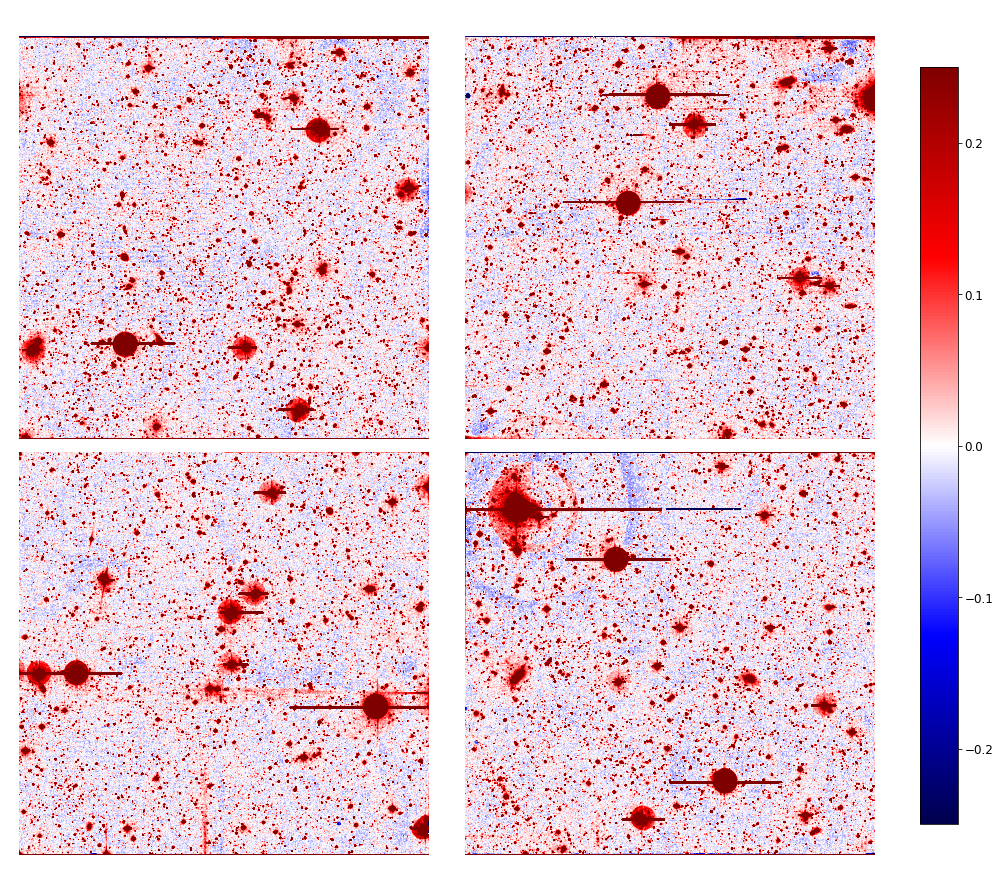

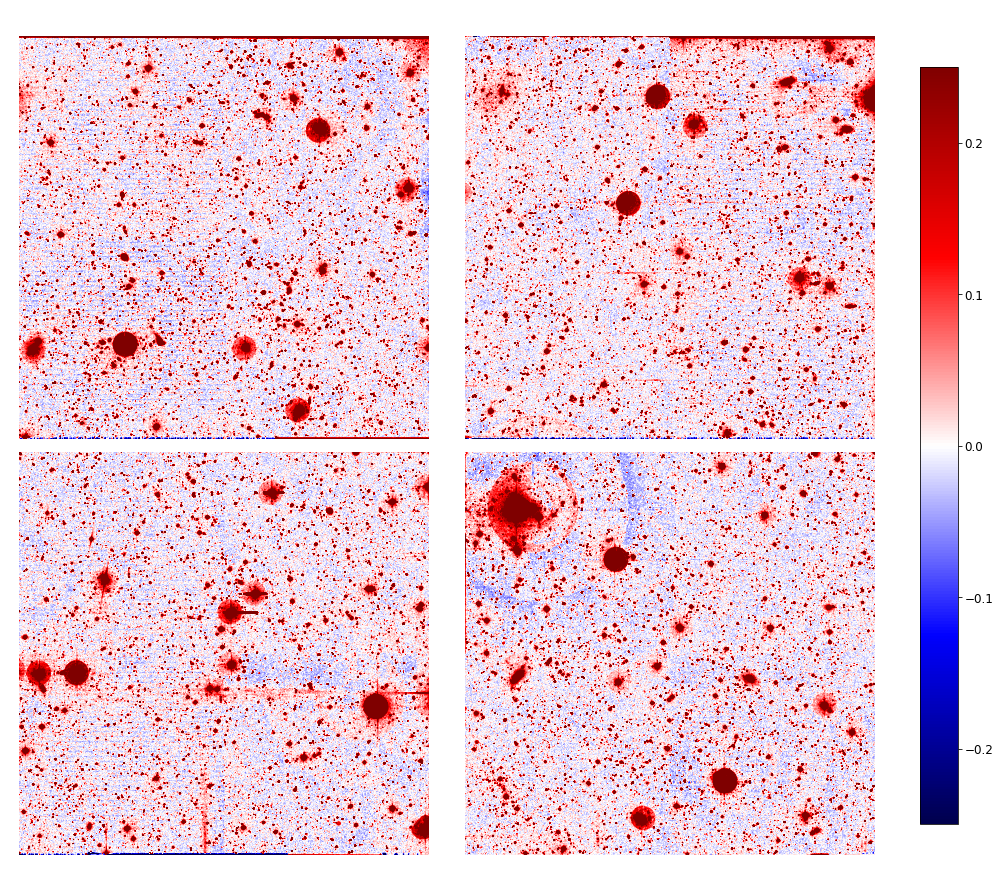

expnum: 74810044
/global/cfs/cdirs/cosmo/staging/90prime/CP/V1.0/CP20160402/ksb_160403_033834_ooi_r_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20160402/ksb_160403_033834_ooi_r_ls9.fits.fz
expnum: 85220098
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20190207/ksb_190208_044225_ooi_r_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20190207/ksb_190208_044225_ooi_r_ls9.fits.fz
expnum: 74050176
/global/cfs/cdirs/cosmo/staging/90prime/CP/V1.0/CP20160117/ksb_160118_073345_ooi_r_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20160117/ksb_160118_073345_ooi_r_ls9.fits.fz
expnum: 74250179
/global/cfs/cdirs/cosmo/staging/90prime/CP/V1.0/CP20160206/ksb_160207_131247_ooi_r_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20160206/ksb_160207_131247_ooi_r_ls9.fits.fz
expnum: 82610141
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.1/CP20180522/ksb_180523_105132_ooi_r_v1.fits.fz
/global/cfs/cdirs/cosmo/staging/90prime/CP/V2.3/CP20180522/ksb_18

In [17]:
vrange = 0.25
binsize = 1
pix_size = 0.454/3600*binsize

for index, expnum in enumerate(expnum_list[:20]):
    
    print('expnum:', expnum)

    # Find an arbitrary CCD in the exposure to get the image filename
    ccd_index_dr8 = np.where((dr8['expnum']==expnum))[0][0]
    ccd_index_dr9 = np.where((dr9['expnum']==expnum))[0][0]

    image_path_dr9fg = os.path.join(image_dir, dr9['image_filename'][ccd_index_dr9].strip())
    image_path_dr8 = os.path.join(image_dir, dr8['image_filename'][ccd_index_dr8].strip().replace('90prime/BOK_CP/', '90prime/CP/'+dr8['plver'][ccd_index_dr9]+'/'))
    # if 'NonDECaLS-DR8' in dr8['image_filename'][ccd_index_dr8]:
    #     # image_path_dr8 = '/global/projecta/projectdirs/cosmo/staging/' + dr8['image_filename'][ccd_index_dr8].strip()
    #     print('skip NonDECaLS')
    #     continue
    
    if not os.path.isfile(image_path_dr8):
        print('Not found:', image_path_dr8)
        print(dr8['image_filename'][ccd_index_dr8])
        continue
    
    print(image_path_dr8)
    print(image_path_dr9fg)

    ############################## dr9 images ##############################

    plt.figure(figsize=(14, 14))

    for ii, ccdnum in enumerate(ccdnum_list):
        
        try:
            img = fits.getdata(image_path_dr9fg, extname='CCD'+str(ccdnum))
        except:
            print('Failure loading {}'.format(image_path_dr9fg))
            continue
            
        # ################ downsize image ################

        # # trim edges to enable downsizing
        # # trimmed image size need to be multiples of binsize
        # trim_size_x = img.shape[1] % binsize
        # trim_size_y = img.shape[0] % binsize
        # img = img[:(img.shape[0]-trim_size_y), :(img.shape[1]-trim_size_x)]
        # # print(img.shape)

        # # to ignore NAN values, use np.nanmean
        # img = np.mean(np.mean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)

        # ################################################

        ysize, xsize = img.shape        
        ra, dec = ccd_ra[ii], ccd_dec[ii]

        # naive sky estimation
        mask = (img<np.percentile(img.flatten(), 95))
        median_sky = np.median(img[mask].flatten())
        
        img = img - median_sky
        img[~np.isfinite(img)] = 0
        img = gaussian_filter(img, 4, mode='reflect', truncate=3)
        fig = plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange, 
                   extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))

    plt.axis([0.55, -0.55, -0.55, 0.55])
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.colorbar(fraction=0.04, pad=0.04)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, os.path.basename(image_path_dr9fg).replace('.fits.fz', '.png')))
    if index==0:
        plt.show()
    plt.close()

    ############################## DR8 images ##############################
    
    plt.figure(figsize=(14, 14))

    for ii, ccdnum in enumerate(ccdnum_list):
        
        try:
            img = fits.getdata(image_path_dr8, extname='CCD'+str(ccdnum))
        except:
            print('Failure loading {}'.format(image_path_dr8))
            continue

        # ################ downsize image ################

        # # trim edges to enable downsizing
        # # trimmed image size need to be multiples of binsize
        # trim_size_x = img.shape[1] % binsize
        # trim_size_y = img.shape[0] % binsize
        # img = img[:(img.shape[0]-trim_size_y), :(img.shape[1]-trim_size_x)]
        # # print(img.shape)

        # # to ignore NAN values, use np.nanmean
        # img = np.mean(np.mean(img.reshape((img.shape[0]//binsize, binsize, img.shape[1]//binsize,-1)), axis=3), axis=1)

        # ################################################

        ysize, xsize = img.shape        
        ra, dec = ccd_ra[ii], ccd_dec[ii]

        # naive sky estimation
        mask = (img<np.percentile(img.flatten(), 95))
        median_sky = np.median(img[mask].flatten())
        
        img = img - median_sky
        img[~np.isfinite(img)] = 0
        img = gaussian_filter(img, 4, mode='reflect', truncate=3)
        fig = plt.imshow(img.T, cmap='seismic', vmin=-vrange, vmax=vrange, 
                   extent=(ra-ysize*pix_size/2, ra+ysize*pix_size/2, dec-xsize*pix_size/2, dec+xsize*pix_size/2))

    plt.axis([0.55, -0.55, -0.55, 0.55])
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.colorbar(fraction=0.04, pad=0.04)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, os.path.basename(image_path_dr8).replace('.fits.fz', '.png')))
    if index==0:
        plt.show()
    plt.close()